In [23]:
import io
import os
import pathlib
import requests
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import dummy, feature_extraction, metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick


In [2]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [3]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [4]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [5]:
vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.9, # ignore words that show up in more than 90% of reviews
    "min_df": 0.1, # ignore words than show up in less than 10% of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
}

features_preprocessing = pipeline.make_pipeline(
    feature_extraction.text.TfidfVectorizer(
        **vectorizer_hyperparams,
    ),
    preprocessing.FunctionTransformer(lambda csr: csr.toarray(), lambda arr: sparse.csr_matrix(arr))
)

label_encoder = preprocessing.LabelEncoder()

In [6]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = label_encoder.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = label_encoder.fit_transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = label_encoder.fit_transform(test_df.loc[:, "sentiment"])


In [14]:
train_accuracy = []
val_accuracy = []
max_depths = [1, 2, 4, 8, 16, 32, 64]

for max_depth in max_depths:
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth)
    classifier.fit(X_train, y_train)
    train_accuracy.append(classifier.score(X_train, y_train))
    val_accuracy.append(classifier.score(X_val, y_val))


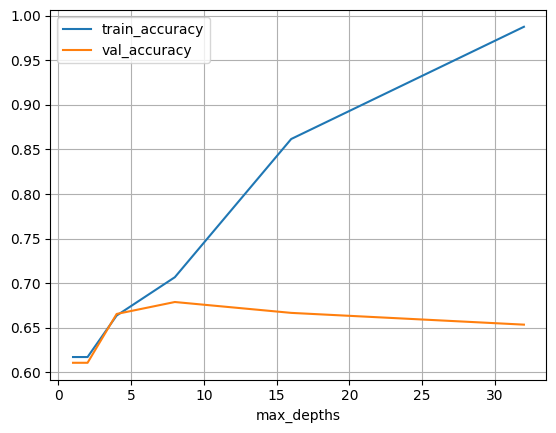

In [15]:
_ = (pd.DataFrame
       .from_dict(
           {
               "train_accuracy": train_accuracy,
               "val_accuracy": val_accuracy,
               "max_depths": max_depths
           },
       ).set_index("max_depths")
        .plot(grid=True)
)

In [16]:
classifier = tree.DecisionTreeClassifier(max_depth=8)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [17]:
print(f"Training accuracy: {classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {classifier.score(X_val, y_val)}")

Training accuracy: 0.70665
Validation accuracy: 0.6786


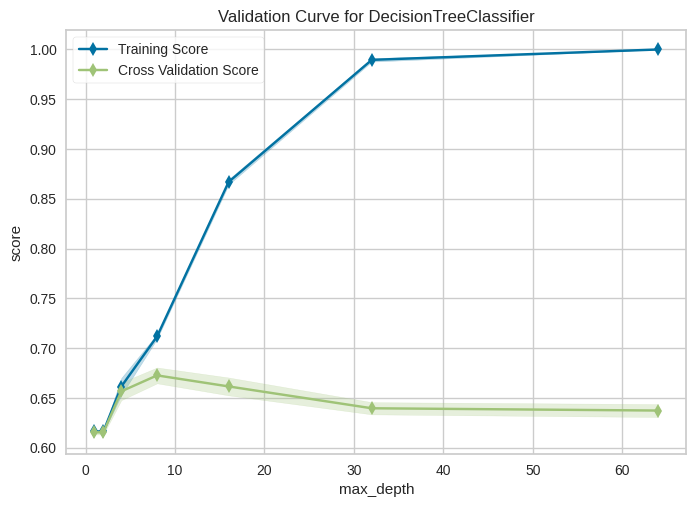

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for DecisionTreeClassifier'}, xlabel='max_depth', ylabel='score'>,
                cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                param_name='max_depth',
                param_range=array([ 1,  2,  4,  8, 16, 32, 64]),
                scoring='accuracy')

In [27]:
from yellowbrick.model_selection import validation_curve


_ = validation_curve(
    tree.DecisionTreeClassifier(),
    X=np.vstack([X_train, X_val]),
    y=np.hstack([y_train, y_val]),
    param_name="max_depth",
    param_range=[1, 2, 4, 8, 16, 32, 64],
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

In [30]:
hyperparam_grid = {
    "max_depth": [1, 2, 4, 8, 16],
    "min_samples_split": [2, 512, 1024],
    "min_samples_leaf": [1, 512, 1024],
}

grid_search_cv = model_selection.GridSearchCV(
    tree.DecisionTreeClassifier(),
    param_grid=hyperparam_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

_ = grid_search_cv.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))

Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [31]:
grid_search_cv.best_params_

{'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 1024}

In [32]:
grid_search_cv.best_score_

0.6814

In [33]:
(pd.DataFrame(grid_search_cv.cv_results_)
   .sort_values(by='rank_test_score')
   .style
   .background_gradient(axis='rows'))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
38,3.189442,0.420365,0.004366,0.000083,16,1,1024,"{'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 1024}",0.675533,0.681133,0.687533,0.681400,0.004903,1
41,2.712830,0.547190,0.005919,0.000713,16,512,1024,"{'max_depth': 16, 'min_samples_leaf': 512, 'min_samples_split': 1024}",0.671400,0.678533,0.684400,0.678111,0.005316,2
40,1.930612,0.024934,0.004635,0.000317,16,512,512,"{'max_depth': 16, 'min_samples_leaf': 512, 'min_samples_split': 512}",0.671400,0.678533,0.684400,0.678111,0.005316,2
39,1.915060,0.015233,0.004854,0.000615,16,512,2,"{'max_depth': 16, 'min_samples_leaf': 512, 'min_samples_split': 2}",0.671400,0.678533,0.684400,0.678111,0.005316,2
37,3.053611,0.124279,0.004510,0.000053,16,1,512,"{'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 512}",0.669400,0.676333,0.684267,0.676667,0.006074,5
29,2.073365,0.030404,0.004482,0.000133,8,1,1024,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 1024}",0.670733,0.672333,0.682733,0.675267,0.005320,6
44,1.595646,0.130220,0.004401,0.000075,16,1024,1024,"{'max_depth': 16, 'min_samples_leaf': 1024, 'min_samples_split': 1024}",0.668867,0.673400,0.681200,0.674489,0.005094,7
43,1.652684,0.022709,0.004496,0.000380,16,1024,512,"{'max_depth': 16, 'min_samples_leaf': 1024, 'min_samples_split': 512}",0.668867,0.673400,0.681200,0.674489,0.005094,7
42,1.674237,0.052204,0.004440,0.000088,16,1024,2,"{'max_depth': 16, 'min_samples_leaf': 1024, 'min_samples_split': 2}",0.668867,0.673400,0.681200,0.674489,0.005094,7
28,2.216465,0.008371,0.004412,0.000108,8,1,512,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 512}",0.667333,0.670867,0.682267,0.673489,0.006372,10


In [36]:
classifier = tree.DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1
)

scores = model_selection.cross_val_score(
    classifier,
    X=np.vstack([X_train, X_val]),
    y=np.hstack([y_train, y_val]),
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished


In [37]:
scores.mean()

0.6696888888888889